In [65]:
def learn_HAT_common_A_adagrad(case, E_source, E_target, a, b, num_iter=1000, lr=1, dis=False, cost_function='abs',
                      H_source_known=None, A_known=None, T_source_known=None,
                      H_target_known=None, T_target_known=None,
                      random_seed=0, eps=1e-8, penalty_coeff=0.0, alpha=None):


    def cost_l21(H_source, A, T_source, H_target, T_target, E_source, E_target, case, lam=0.1, alpha=None):
        if alpha is None:
            alpha = 1.*np.shape(H_source)[0]/(np.shape(H_source)[0] + np.shape(H_target)[0])
        HAT_source = multiply_case(H_source, A, T_source, case)
        HAT_target = multiply_case(H_target, A, T_target, case)
        
        mask_source = ~np.isnan(E_source)
        mask_target = ~np.isnan(E_target)
        
        error_source = (HAT_source - E_source)[mask_source].flatten()
        error_target = (HAT_target - E_target)[mask_target].flatten()
        
        A_shape = A.shape
        A_flat = A.reshape(A_shape[0], A_shape[1]*A_shape[2])
        l1 = 0.
        for j in range(A_shape[0]):
            l1 = l1 + np.sqrt(np.square(A_flat[j,:]).sum())
            #print(j, l1)
        # return np.sqrt((error ** 2).mean()) + lam*np.sum(A[A!=0])
        return alpha* np.sqrt((error_source ** 2).mean()) + (1-alpha)* np.sqrt((error_target ** 2).mean()) + lam * l1


    mg = multigrad(cost_l21, argnums=[0, 1, 2, 3, 4])

    params_source = {'a':a,'b':b}
    params_target = {'a':a,'b':b}
    params_source['M'], params_source['N'], params_source['O'] = E_source.shape
    params_target['M'], params_target['N'], params_target['O'] = E_target.shape
    
    def create_initial_HAT(params):
        H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
        H_dim = tuple(params[x] for x in H_dim_chars)
        A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
        A_dim = tuple(params[x] for x in A_dim_chars)
        T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
        T_dim = tuple(params[x] for x in T_dim_chars)
        H = np.random.rand(*H_dim)
        A = np.random.rand(*A_dim)
        T = np.random.rand(*T_dim)
        return H, A, T

    H_source, A, T_source = create_initial_HAT(params_source)
    H_target, A, T_target = create_initial_HAT(params_target)

    sum_square_gradients_H_source = np.zeros_like(H_source)
    sum_square_gradients_H_target = np.zeros_like(H_target)
    
    sum_square_gradients_A = np.zeros_like(A)
    
    sum_square_gradients_T_source = np.zeros_like(T_source)
    sum_square_gradients_T_target = np.zeros_like(T_target)

    Hs_source = [H_source.copy()]
    Hs_target = [H_target.copy()]
    
    As = [A.copy()]
    
    Ts_source = [T_source.copy()]
    Ts_target = [T_target.copy()]
    
    costs = [cost_l21(H_source, A, T_source, H_target, T_target, E_source, E_target, case, penalty_coeff, alpha)]
    
    HATs_source = [multiply_case(H_source, A, T_source, 2)]
    HATs_target = [multiply_case(H_target, A, T_target, 2)]

    # GD procedure
    for i in range(num_iter):
        
        del_h_source, del_a, del_t_source, del_h_target, del_t_target = mg(H_source,
                                                                           A, 
                                                                           T_source,
                                                                           H_target,
                                                                           T_target,
                                                                           E_source,
                                                                           E_target,
                                                                           case, penalty_coeff, alpha)
        sum_square_gradients_H_source += eps + np.square(del_h_source)
        sum_square_gradients_H_target += eps + np.square(del_h_target)
        
        sum_square_gradients_A += eps + np.square(del_a)
        
        sum_square_gradients_T_source += eps + np.square(del_t_source)
        sum_square_gradients_T_target += eps + np.square(del_t_target)

        lr_h_source = np.divide(lr, np.sqrt(sum_square_gradients_H_source))
        lr_h_target = np.divide(lr, np.sqrt(sum_square_gradients_H_target))
        
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        
        lr_t_source = np.divide(lr, np.sqrt(sum_square_gradients_T_source))
        lr_t_target = np.divide(lr, np.sqrt(sum_square_gradients_T_target))

        H_source -= lr_h_source * del_h_source
        H_target -= lr_h_target * del_h_target
        
        A -= lr_a * del_a
        
        T_source -= lr_t_source * del_t_source
        T_target -= lr_t_target * del_t_target
        
        # Projection to known values
        if H_source_known is not None:
            H_source = set_known(H_source, H_source_known)
        if H_target_known is not None:
            H_target = set_known(H_target, H_target_known)
            
        if A_known is not None:
            A = set_known(A, A_known)
            
        if T_source_known is not None:
            T_source = set_known(T_source, T_source_known)
        if T_target_known is not None:
            T_target = set_known(T_target, T_target_known)
        
        # Projection to non-negative space
        H_source[H_source < 0] = 1e-8
        H_target[H_target < 0] = 1e-8
        
        A[A < 0] = 1e-8
        
        T_source[T_source < 0] = 1e-8
        T_target[T_target < 0] = 1e-8

        As.append(A.copy())
        Ts_source.append(T_source.copy())
        Ts_target.append(T_target.copy())
        
        Hs_source.append(H_source.copy())
        Hs_target.append(H_target.copy())
        
        costs.append(cost_l21(H_source, A, T_source, H_target, T_target, E_source, E_target, 
                              case, penalty_coeff, alpha=alpha))
        HATs_source.append(multiply_case(H_source, A, T_source, 2))
        HATs_target.append(multiply_case(H_target, A, T_target, 2))

        if i % 500 == 0:
            if dis:
                print(cost_l21(H_source, A, T_source, H_target, T_target, E_source, E_target, 
                              case, penalty_coeff, alpha=alpha))
    return H_source, A, T_source, H_target, T_target, Hs_source, As, Ts_source, Hs_target, Ts_target,HATs_source, HATs_target, costs


In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [67]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [68]:
n_splits = 10
import sys
case=2
a=2

In [69]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [70]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values


In [71]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)
static_sd = df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values


In [72]:
E_source = au_tensor.copy()
E_target = tensor.copy()
a = 5
b = 2


H_source, A, T_source, H_target, T_target, Hs_source, As, Ts_source, Hs_target, Ts_target,HATs_source, HATs_target, costs = learn_HAT_common_A_adagrad(case, E_source, E_target, a, b, num_iter=1000, lr=1, dis=False, cost_function='l21',
                      H_source_known=None, A_known=None, T_source_known=None,
                      H_target_known=None, T_target_known=None,
                      random_seed=0, eps=1e-8, penalty_coeff=0.01, alpha=None)

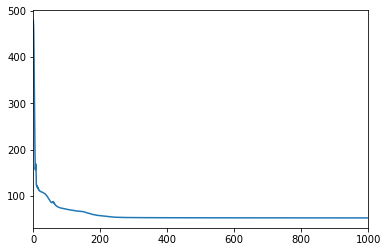

In [73]:
pd.Series(costs).plot()

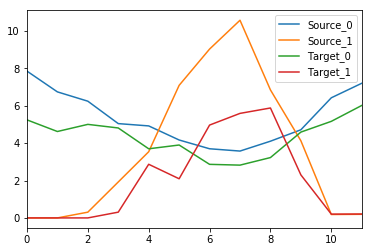

In [80]:
ax = pd.DataFrame(T_source).plot()
pd.DataFrame(T_target).plot(ax=ax)
plt.legend(['Source_0', 'Source_1','Target_0','Target_1'])

In [82]:
from sklearn.model_selection import train_test_split, KFold

In [95]:
pred = {}
sd = {}
out = {}
n_splits = 10
NUM_RANDOM = 2
TRAIN_SPLITS = range(10, 110, 40)
case = 2
num_home = 5
n_iter=1200
import datetime

cost = 'l21'
algo = 'adagrad'
for static_fac in ['static',None]:
    if static_fac is None:
        H_known_Au = None
        H_known_Sd = None
    else:
        H_known_Au = static_au
        H_known_Sd = static_sd
    np.random.seed(0)
    pred[static_fac] = {}
    #for lam in [1e-2, 100]:
    for lam in [1e-3, 1e-2, 1e-1, 0]:
    #for lam in [1e-3]:
        pred[static_fac][lam] = {}
        for a in range(2, 3):
            
            pred[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                pred[static_fac][lam][a][random_seed] = {}
                for appliance in APPLIANCES_ORDER:
                    pred[static_fac][lam][a][random_seed][appliance] = {f:[] for f in TRAIN_SPLITS}

            kf = KFold(n_splits=n_splits)
            for random_seed in range(NUM_RANDOM):

                for train_percentage in TRAIN_SPLITS:
                    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
                    
                    print(lam, static_fac, a, random_seed,train_percentage, now)
                    for train_max, test in kf.split(df):

                        num_train = int((train_percentage*len(train_max)/100)+0.5)
                        if train_percentage==100:
                            train = train_max
                        else:
                            train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                        train_ix = df.index[train]
                        test_ix = df.index[test]

                        num_test = len(test_ix)
                        train_test_ix = np.concatenate([test_ix, train_ix])
                        df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
                        tensor = get_tensor(df_t, dfc_t)
                        tensor_copy = tensor.copy()
                        # First n
                        tensor_copy[:num_test, 1:, :] = np.NaN
                        if static_fac is not None:
                            
                            H_source, A, T_source, H_target, T_target, Hs_source, As, Ts_source, Hs_target, Ts_target,HATs_source, HATs_target, costs  =  learn_HAT_common_A_adagrad(case, au_tensor, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function='l21',
                      H_source_known=H_known_Au, A_known=None, T_source_known=None,
                      H_target_known=H_known_Sd[np.concatenate([test, train])], T_target_known=None,
                      random_seed=0, eps=1e-8, penalty_coeff=lam, alpha=None)
                            
                        else:
                            H_source, A, T_source, H_target, T_target, Hs_source, As, Ts_source, Hs_target, Ts_target,HATs_source, HATs_target, costs  =  learn_HAT_common_A_adagrad(case, au_tensor, tensor_copy, num_home, a, num_iter=n_iter, lr=1, dis=False, cost_function='l21',
                      H_source_known=None, A_known=None, T_source_known=None,
                      H_target_known=None, T_target_known=None,
                      random_seed=0, eps=1e-8, penalty_coeff=lam, alpha=None)
                       
                        HAT_target = multiply_case(H_target, A, T_target, case)
                        for appliance in APPLIANCES_ORDER:
                            pred[static_fac][lam][a][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT_target[:num_test, appliance_index[appliance], :], index=test_ix))


(0.001, 'static', 2, 0, 10, '2017-07-31 13:31')
(0.001, 'static', 2, 0, 50, '2017-07-31 13:34')
(0.001, 'static', 2, 0, 90, '2017-07-31 13:37')
(0.001, 'static', 2, 1, 10, '2017-07-31 13:39')
(0.001, 'static', 2, 1, 50, '2017-07-31 13:42')
(0.001, 'static', 2, 1, 90, '2017-07-31 13:45')
(0.01, 'static', 2, 0, 10, '2017-07-31 13:47')
(0.01, 'static', 2, 0, 50, '2017-07-31 13:50')
(0.01, 'static', 2, 0, 90, '2017-07-31 13:53')
(0.01, 'static', 2, 1, 10, '2017-07-31 13:56')
(0.01, 'static', 2, 1, 50, '2017-07-31 13:58')
(0.01, 'static', 2, 1, 90, '2017-07-31 14:01')
(0.1, 'static', 2, 0, 10, '2017-07-31 14:04')
(0.1, 'static', 2, 0, 50, '2017-07-31 14:06')
(0.1, 'static', 2, 0, 90, '2017-07-31 14:09')
(0.1, 'static', 2, 1, 10, '2017-07-31 14:12')
(0.1, 'static', 2, 1, 50, '2017-07-31 14:15')
(0.1, 'static', 2, 1, 90, '2017-07-31 14:18')
(0, 'static', 2, 0, 10, '2017-07-31 14:21')
(0, 'static', 2, 0, 50, '2017-07-31 14:24')
(0, 'static', 2, 0, 90, '2017-07-31 14:27')
(0, 'static', 2, 1, 10

In [96]:
from common import compute_rmse_fraction

In [98]:
out = {}
algo = 'adagrad'
for static_fac in ['static',None]:
    out[static_fac] = {}
    for lam in [1e-3, 1e-2, 1e-1, 0]:
        print(lam, static_fac)
        out[static_fac][lam] = {}
        for a in range(2, 3):
            out[static_fac][lam][a] = {}
            for random_seed in range(NUM_RANDOM):
                out[static_fac][lam][a][random_seed] = {}

                for appliance in APPLIANCES_ORDER[1:]:
                    out[static_fac][lam][a][random_seed][appliance] = {}
                    for f in TRAIN_SPLITS:
                        s = pd.concat(pred[static_fac][lam][a][random_seed][appliance][f]).ix[df.index]
                        if appliance=="hvac":
                            out[static_fac][lam][a][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                        else:   
                            out[static_fac][lam][a][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

(0.001, 'static')


/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


(0.01, 'static')
(0.1, 'static')
(0, 'static')
(0.001, None)
(0.01, None)
(0.1, None)
(0, None)


6.01196420719
5.73350722184
5.73169859451
5.82304591483


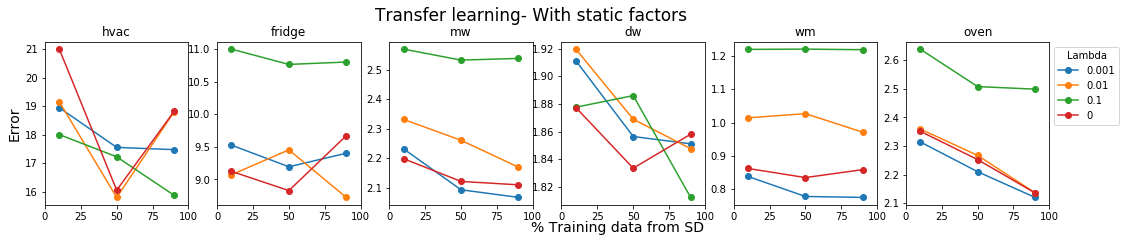

In [104]:
static_res = {}
fig, ax = plt.subplots(ncols=6, figsize=(18, 3))

for lam in [1e-3, 1e-2, 1e-1, 0]:
    static_res[lam] = pd.Panel(out['static'][lam][2]).mean(axis=0)
    for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
        static_res[lam][appliance].plot(ax=ax[i], marker='o', title=appliance)
        ax[i].set_xlim((0, 100))
plt.legend([1e-3, 1e-2, 1e-1, 0], bbox_to_anchor=(1, 1), title='Lambda')
fig.text(0.5, 0, "% Training data from SD", fontsize=14)
ax[0].set_ylabel("Error", fontsize=14)
plt.suptitle("Transfer learning- With static factors", fontsize=17,y=1.04)

print static_res[0.1].mean().mean()
print static_res[0.01].mean().mean()
print static_res[0.001].mean().mean()
print static_res[0.0].mean().mean()
#print static_res[1].mean().mean()

5.61534696842
5.76252198801
5.70170394504
5.61139553827


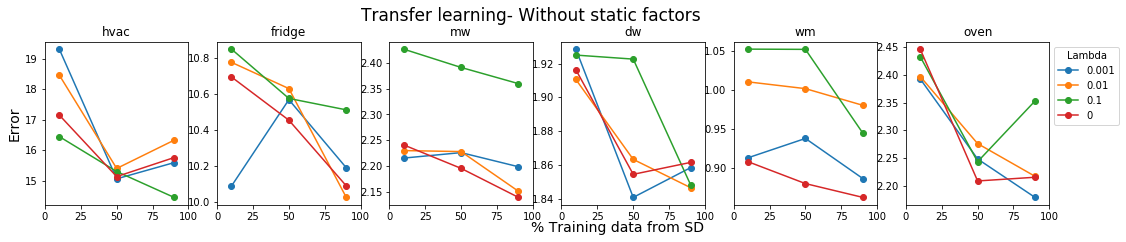

In [103]:
static_res = {}
fig, ax = plt.subplots(ncols=6, figsize=(18, 3))

for lam in [1e-3, 1e-2, 1e-1, 0]:
    static_res[lam] = pd.Panel(out[None][lam][2]).mean(axis=0)
    for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
        static_res[lam][appliance].plot(ax=ax[i], marker='o', title=appliance)
        ax[i].set_xlim((0, 100))
plt.legend([1e-3, 1e-2, 1e-1, 0], bbox_to_anchor=(1, 1), title='Lambda')
fig.text(0.5, 0, "% Training data from SD", fontsize=14)
ax[0].set_ylabel("Error", fontsize=14)
plt.suptitle("Transfer learning- Without static factors", fontsize=17,y=1.04)

print static_res[0.1].mean().mean()
print static_res[0.01].mean().mean()
print static_res[0.001].mean().mean()
print static_res[0.0].mean().mean()
#print static_res[1].mean().mean()

In [102]:
import pickle
pickle.dump(out, open('predictions/global-sparse-static-normalised.pkl','w'))